# Dealing with real data

In the previous notebook we completed our fitting pipeline and tested it using synthetic data.
In this notebook we discuss some of the difficulties you'll encounter when working with real data.

To illustrate this we will show some real data (recorded by Kylie Beattie for ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP275733)), but we'll also take a step-by-step approach to build up a _model_ of the experimental noise and "artefacts" encountered in voltage-clamping, as was done in ["Accounting for variability in ion current recordings using a mathematical model of artefacts in voltage-clamp experiments"](https://doi.org/10.1098/rsta.2019.0348) by Chon Lok Lei et al., 2020.

Some amazing background reading for this notebook can be found in ["Electronic design of the patch clamp"](https://scholar.google.com/scholar?q=Sigworth+Electronic+design+of+the+patch+clamp) by Fred J Sigworth, 1995. This is available as Chapter 4 of the (excellent) book "Single-Channel Recording" edited by Neher and Sakmann, but a digital copy of the chapter has also been made available online by its author.
A great (and much shorter) practical guide to patch clamp experiments can be found in "Patch Clamping: An Introductory Guide to Patch Clamp Electrophysiology", by Areles Molleman.

## General strategies for dealing with noise and artefacts

_The following discussion provides a high-level view of the issues that will be dealt with in this notebook. For a step-by-step approach, please skip straight to the next section!_

Four strategies for dealing with noise and artefacts are:

- Avoiding it
- On-line correction (with hardware of software)
- Off-line correction (post-processing)
- Modelling

**Avoiding noise** is a major part of experimental setup and hardware design, and can include [shielding](https://en.wikipedia.org/wiki/Faraday_cage), removing sources of electronic inference (e.g. monitors, lights), using special power supplies (or batteries), checking for [ground loops](https://en.wikipedia.org/wiki/Ground_loop_%28electricity%29), and even cooling part of the measurement equipment to reduce [thermal noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise).

**On-line correction** using hardware filters is common in patch-clamp experiments, and includes correction of capacitance artefacts, series resistance compensation, "zeroing" the current, and low-pass filtering (all discussed below).
A major downside of on-line correction is that it can only be performed once.
In addition, most patch-clamp hardware does not provide digital readouts of the controls used to perform on-line correction, so that information about how exactly the signal was modulated is lost.

**Off-line correction** includes leak correction and removal of any remaining capacitance artefacts, but may also include removing endogenous currents by subtracting a second measurement made in the presence of a current-blocking drug.
A downside of both on-line and off-line correction is that it invariably "complicates" the recording.
For example, to fully model a typical patch-clamp measurement it would be necessary to understand the ionic current, the way the cell and patch-clamp setup contaminate this recording, and the precise way in which hardware and offline software has attempted to remedy these effects.

A different approach then, is to simply leave the noise and artefacts in, and **add them to the model used in the fitting procedure**.
The most common example of "modelling" the noise, is using a root-mean-squared error when fitting the data: statistically this equates to assuming a Gaussian model for the noise (so that the recorded current at any time point equals the ionic current plus a normally distributed random variable).
More complex modelling approaches are also possible, and will be discussed here based on [Lei et al., 2020](https://royalsocietypublishing.org/doi/10.1098/rsta.2019.0348).
However, it should be stressed that such an approach has downside too.
Mathematically, a model of ionic current plus unknown noise sources may be unidentifiable.
More practically, some forms of on-line filtering are unavoidable (e.g. low-pass filtering and pipette capacitance compensation, see below).

Finally, it should be remembered that patch-clamping is a two-way process: The cell is perturbed somehow, and we measure its response.
So in addition to errors in the measured response, we should also consider errors due to **imperfect control**.
Imperfect control includes lack of precision in setting factors such as temperature (often quoted as being in a 1-2 degree bracket) or external solutions (especially with e.g. fast wash-out or wash-in).
But the major factor that will be considered below is imperfect control of the membrane potential.
This includes static differences, e.g. due to the [liquid junction potential](https://en.wikipedia.org/wiki/Liquid_junction_potential), but also dynamical changes, e.g. due to the combination of the series (access) resistance and cell membrane acting as an [RC circuit](https://en.wikipedia.org/wiki/RC_circuit).
A common on-line correction for this is "series resistance compensation", but we will study alternative methods of dealing with the remaining series resistance effects below.

## Modelling noise as well as ion current

A central idea in this notebook will be to differentiate between the measured current, $I_\text{measured}$, and the current of interest, which we shall call $I_\text{ion}$.
The relationship between $I_\text{measured}$ and $I_\text{ion}$ can be captured mathematically in a _noise model_:

\begin{equation}
I_\text{measured} = f(I_\text{ion})
\end{equation}

The simplest such noise models are _additive_, and take the form

\begin{equation}
I_\text{measured} = I_\text{ion} + I_\text{unwanted}
\end{equation}

But we shall also see some more complicated forms.
In particular, we shall look at the case where the membrane voltage, $V_m$, differs from the _intended_ voltage, $V_\text{command}$, so that instead of measuring $I_\text{ion}(V_\text{command}(t), t)$ we actually measure some function

\begin{equation}
I_\text{measured} = f \big( I_\text{ion}(V_m) \big) = f \big( I_\text{ion}(g(V_\text{command})) \big)
\end{equation}

<img src="resources/patch-clamp-1-mystery.png" width="598px" />

# TODO: It gets trickier still: g is a function of I_ion 

In this notebook and the next, we'll show some variations on the diagram above, adapted from [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348), to see how various noise sources can be understood and hopefully dealt with.

## Stochastic noise

An additive noise source we've already seen throughout these notebooks, is

\begin{equation}
I_\text{measured} = I_\text{ion} + I_\text{stochastic} = I_\text{ion} + \mathcal{N}(0, \sigma)
\end{equation}

That is, we assumed the measured signal was the current of interest plus some stochastic noise with a fixed standard deviation $\sigma$.
A model like this assumes that
- the noise in sample $I_m[i]$ is independent of the noise at $I_\text{measured}[i-1]$ (or more generally, that it is independent of the noise in any sample $I_\text{measured}[j \neq i]$)
- the noise follows a normal distribution with mean zero and standard deviation $\sigma$, where $\sigma$ is constant over time and independent of $I_\text{ion}$.

This model can be used for noise that is truly stochastic, but perhaps also for processes that change quickly enough to _look_ stochastic, given our sampling rate.
Noise that _more or less_ matches these assumptions can arise from from the electronics e.g. [thermal noise](https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise), and [shot noise](https://en.wikipedia.org/wiki/Shot_noise).
(For more on sources of noise, see [Sigworth 1995](https://scholar.google.com/scholar?q=Sigworth+Electronic+design+of+the+patch+clamp), [Benndorf 1995](https://scholar.google.com/scholar?q=benndorf+low+noise+recording), or the [Axon Guide](https://www.moleculardevices.com/en/assets/ebook/dd/cns/axon-guide-to-electrophysiology-and-biophysics-laboratory-techniques).)
We might even expect some fluctuations from the stochastic opening and closing of the channels themselves: a 1973 paper by [Anderson and Stevens](https://doi.org/10.1113/jphysiol.1973.sp010410) showed that "channel noise" with a high enough amplitude can be analysed to estimate the number of channels in a cell.


It can be worthwhile to examine these assumptions, for example by looking at a "boring" part of an experimental result, where the voltage is stable and the channels are assumed to be in or near their steady state.

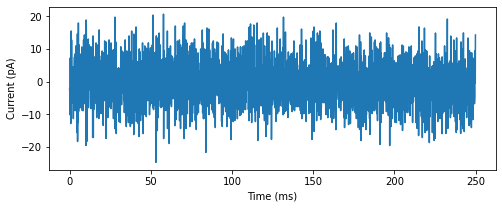

In [1]:
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pints
import scipy.stats

# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('resources/sine-wave-data/cell-1.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

plt.figure(figsize=(8, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(log.time(), log['current'] * 1000)  # Convert from nA to pA
plt.show()

We can try and visually inspect this data, for example to see how it compares to a normal distribution:

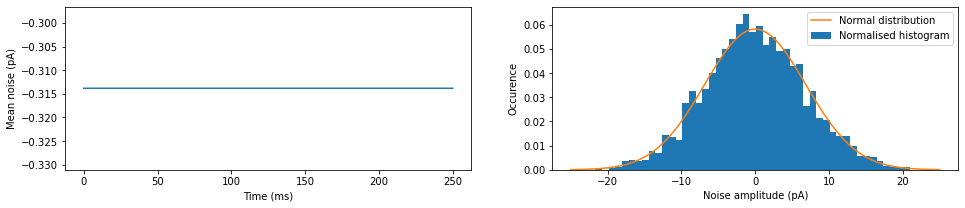

In [2]:
# Subtract the mean and show a histogram of this noise:

noise = log['current'] * 1000 # Convert from nA to pA
offset = np.mean(noise)
variation = noise - offset

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Mean noise (pA)')
ax.plot(log.time(), np.ones(noise.shape) * offset)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Noise amplitude (pA)')
ax.set_ylabel('Occurence')
ax.hist(variation, bins=50, density=True, label='Normalised histogram')

x = np.linspace(-25, 25, 100)
ax.plot(x, scipy.stats.norm.pdf(x, 0, np.std(variation)), label='Normal distribution')
ax.legend()

plt.show()

So the data _looks_ to be normally distributed, although not with a zero offset (more about that later).
More rigorous tests of normality are available, but for large sample sizes like these, they tend to be _too strict_, and reject the hypothesis that the distribution is normal, for even very minor deviations from normality.

Another thing we can investigate is whether the noise in this cell was _independent and identically distributed_ (i.i.d.).
A quick visual way to do that is to make a plot of the _autocorrelation_, this shows you how much the points at any index $i$ correlate with the points at $i - \text{lag}$.
For $\text{lag} = 0$ this is $1$ by definition, but for higher lags this should be close to zero if the noise is iid.
One rule of thumb is to plot the lines at $\pm1.96 \sqrt{n}$, which correspond to the 95% confidence interval, and then check that only 5% of the autocorrelations are outside this interval.

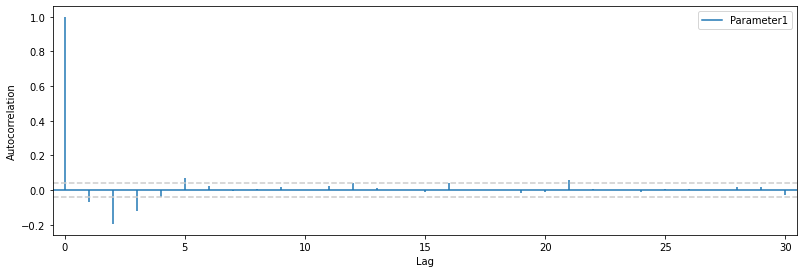

In [3]:
import pints.plot

# pints.plot.autocorrelation expects an array of shape (n_samples, n_parameters)
# See: https://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation
n = len(variation)
reshaped = variation.reshape((n, 1))

fig, ax = pints.plot.autocorrelation(reshaped, max_lags=30)
fig.set_size_inches(12, 5)
ax[0].axhline(+1.96 / np.sqrt(n), ls='--', color='#cccccc')
ax[0].axhline(-1.96 / np.sqrt(n), ls='--', color='#cccccc')
plt.show()

So it looks like our noise is fairly independent!

Now that we now this, how can we use it to help us deal with this noise?
Because the noise is stochastic, we can't model it directly and subtract it from our recordings.
But we _can_ write a statistical model for our noise, and fit that to the data.

First, we assume that at any point intime the measured current $I_m(t)$ can be modelled as the sum of a current model $m(t|p)$ with parameters $p$ and a random variable from a normal distribution with standard deviation $\sigma$:

\begin{equation}
I_\text{measured}(t) = m(t|p) + \mathcal{N}(0, \sigma)
\end{equation}

In the ["basic fitting"](basic-fitting.ipynb) notebook, we saw that this lets us write a _probability density function_ $f$ for obtaining a certain measurement _given_ a fixed $p$ and $\sigma$, and that this could be used to define a _log-likelhood_ for $p$ and $\sigma$ given a particular measurement $D$:

\begin{equation}
\log l(p, \sigma|D) = -\frac{N}{2}\log(2\pi) - N\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i = 1}^{N} \left(I_\text{measured}(t_i) - m(t_i|p)\right)^2
\end{equation}

where $D$ is a digitised set of measurements $D = \{(t_1, I_\text{measured}(t_1)), (t_2, I_\text{measured}(t_2)), ..., (t_N, I_\text{measured}(t_N))\}$.

In the basic fitting tutorial we observed that for a fixed value of $\sigma$ the process of _maximising this log-likelihood_ is the same as _minimising the sum of squared errors_ $I_\text{measured}(t_i) - m(t_i|p)$, and we proceeded using this approach in most of the tutorial.

However, instead of passing in an [ErrorMeasure](https://pints.readthedocs.io/en/latest/error_measures.html), PINTS optimisers can also operate directly on a [LogLikelihood object](https://pints.readthedocs.io/en/latest/log_likelihoods.html):

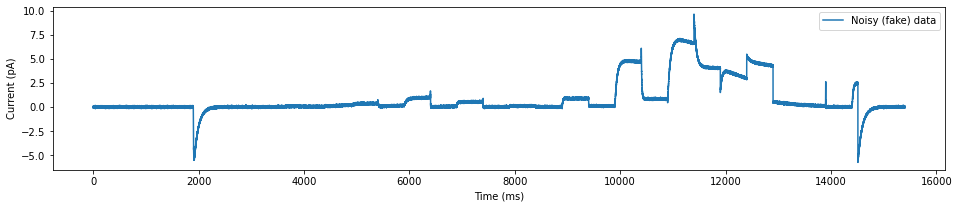

In [4]:
from library import ModelHHSolver

# Set up a simple fitting problem
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-2, 5e-3, 0.03, 0.2])

protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = ModelHHSolver(protocol)
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)
values += np.random.normal(0, 0.05, times.shape)
problem = pints.SingleOutputProblem(model, times, values)

plt.figure(figsize=(16, 3))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy (fake) data')
plt.legend()
plt.show()

Next, we isolate a bit of noise from the start of the signal to estimate sigma:

In [5]:
noise = values[:1000]
sigma = np.std(noise)
print('Estimated sigma: ' + str(sigma))

Estimated sigma: 0.049648738865085064


And we use this to create and maximise a [pints.GaussianKnownSigmaLogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html#pints.GaussianKnownSigmaLogLikelihood):

In [6]:
# Create a log-likelihood object
log_pdf = pints.GaussianKnownSigmaLogLikelihood(problem, sigma)

# Choose a slightly random starting point
x0 = parameters * 2**np.random.normal(0, 0.25, parameters.shape)

# Use an optimiser to maximise it
opt = pints.OptimisationController(log_pdf, x0)
opt.set_log_to_screen(False)
xopt, fopt = opt.run()

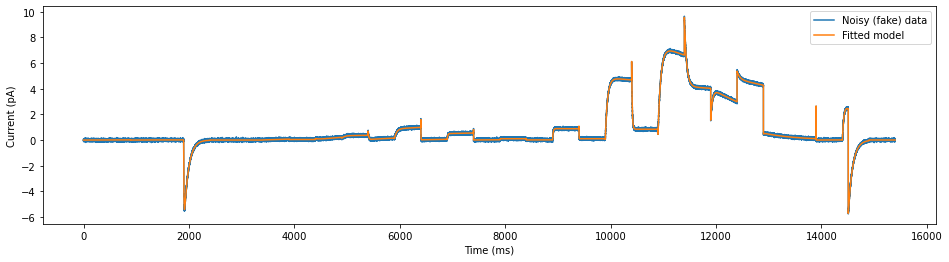

In [7]:
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, values, label='Noisy (fake) data')
plt.plot(times, problem.evaluate(xopt), label='Fitted model')
plt.legend()
plt.show()

Here we followed a two-step process, first estimating sigma from a small chunk of the data and then using this estimate to do the full fit.
But there's nothing stopping us from inferring $\sigma$ along with the rest of the parameters!

In [8]:
# Create an unknown sigma log-likelihood object
log_pdf = pints.GaussianLogLikelihood(problem)

# This log likelihood has one more parameter than our model!
print(model.n_parameters())
print(log_pdf.n_parameters())

9
10


As before, we can use an optimiser to maximise this log-likelihood, but now we need to pass in a starting point that also includes an estimate for sigma:

In [9]:
x0_with_sigma = np.concatenate((x0, [0.3]))

opt = pints.OptimisationController(log_pdf, x0_with_sigma)
opt.set_log_to_screen(False)
xopt, fopt = opt.run()

Now the returned parameter vector includes an extra value for the estimated sigma:

In [10]:
print('Estimated sigma: ' + str(xopt[-1]))

Estimated sigma: 0.0500420491593436


This probabilistic approach opens up new possibilities for investigation.
For example, we could replace the assumption of i.i.d. noise with the assumption that the noise is correlated and would be better described by an [Autoregressive AR1 model](https://en.wikipedia.org/wiki/Autoregressive_model).
We can then replace our Gaussian loglikelihood by a [pints.AR1LogLikelihood](https://pints.readthedocs.io/en/latest/log_likelihoods.html#pints.AR1LogLikelihood) and compare the quality of fit.

Instead of finding the maximum of the proposed likelihood function, we can also use [sampling methods](https://pints.readthedocs.io/en/latest/mcmc_samplers/index.html) to explore the full distribution.
If the model fits the data extremely well, this can provide an estimate of the uncertainty in the obtained parameters.
However, if there is a slight _discrepancy_ between the final model predictions and the experimental recording (as is typically the case in ion current electrophysiology), the results of applying a sampling method are much harder to interpret.

## Periodic noise

In addition to stochastic (additive) noise, we might also look for periodic noise.
An easy way to spot this is by creating and plotting an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) or [power spectrum](https://en.wikipedia.org/wiki/Spectral_density).

We start by defining a quick function to calculate a power spectrum:

In [12]:
def spectrum( times, current):
    """
    Calculates the power spectrum (or spectral density) of a (regularly spaced)
    time series ``(times, current)``, and returns a tuple ``(freq, power)``
    where ``freq`` contains a list of positive frequencies, and ``power``
    is the associated spectral density (if current is in "units", the power will
    be unit "units**2").
    """
    # Import fft functions
    try:
        # Latest scipy
        from scipy.fft import fft, fftshift, fftfreq
    except ImportError:
        from scipy.fftpack import fft, fftshift, fftfreq
    
    # Length of time series (assuming len(times) == len(current))
    n = len(times)
    
    # Time-step (assuming points are equally spaced)
    dt = times[1] - times[0]
           
    # Points in the FFT
    points = fftshift(fft(current)).real
    
    # Frequency of points in the fft
    frequency = fftshift(fftfreq(n, dt))
    
    # Select positive points
    positive = frequency > 0
    
    return frequency[positive], points[positive]**2


Using this function, we can have a look at the start of Cell 1's data again:

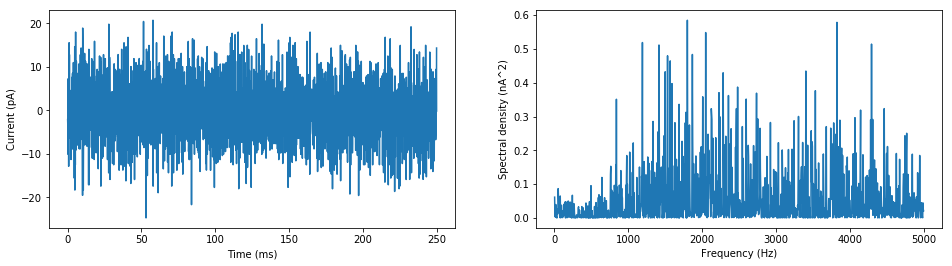

In [13]:
# Load Cell 1 from Beattie et al.
log = myokit.DataLog.load('resources/sine-wave-data/cell-1.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

# Calculate the power spectrum
times = log.time()
current = log['current']
freq, points = spectrum(times * 1e-3, current)  # Using time in seconds to get frequency in Hz

# Show the results
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(times, current * 1e3)  # Convert from nA to pA

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)

plt.show()

So it looks like there's no particular frequencies that dominate the noise in this recording.

Because we recorded at a sample spacing of $0.1\text{ms} = 10^{-4}\text{s}$, the highest frequency observable in the signal is half the sampling rate, so $\frac{1}{2} 1 / 10^{-4}\text{s} = \frac{1}{2} 10\text{kHz} = 5\text{kHz}$.
Notice that the [Nyquist-Shannon sampling theory](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) says something stronger than that; it says that _even lower frequency signals_ can't be reconstructed from a digital recording if frequencies higher than half the sampling rate are present in the signal.
A common way to ensure this is the case, is to use low-pass filtering before digitisation (so this is an example of online filtering that we cannot escape!).
Looking at the [published raw data files](https://figshare.com/articles/Sinusoidal_voltage_protocols_for_rapid_characterization_of_ion_channel_kinetics_supplementary_experimental_data/4702546/1) for this study, we can inspect the meta data (e.g. using [Myokit's DataLog viewer](https://myokit.readthedocs.io/cmd/log.html)) and see that this signal was indeed low-pass filtered at 5kHz before digitisation.

Now let's look at a different recording:

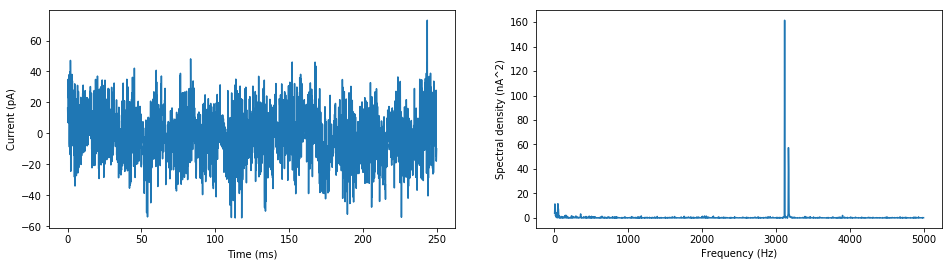

In [14]:
# Load Cell 7 from Beattie et al.
log = myokit.DataLog.load('resources/sine-wave-data/cell-7.zip').npview()

# Isolate a "flat" bit of signal, by chopping off everything after t=250
# During this time, V is fixed at -80mV
log = log.trim_right(250)

# Calculate the power spectrum
times = log.time()
current = log['current']
freq, points = spectrum(times * 1e-3, current)  # Using time in seconds to get frequency in Hz

# Show the results
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(times, current * 1e3)  # Convert from nA to pA

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)

plt.show()

This shows some very different characteristics!

In the power spectrum plot on the right, we can clearly see two peaks around $3.2 \text{kHz}$.
These are most likely from some piece of electronic equipment in the same room or, if the noise is transmitted through the mains or the grounding, somewhere else in the building!

In the direct plot on the left, we can also see what look like some lower frequency periodic effects.
We can do a few zoomed plots to get a clearer picture:

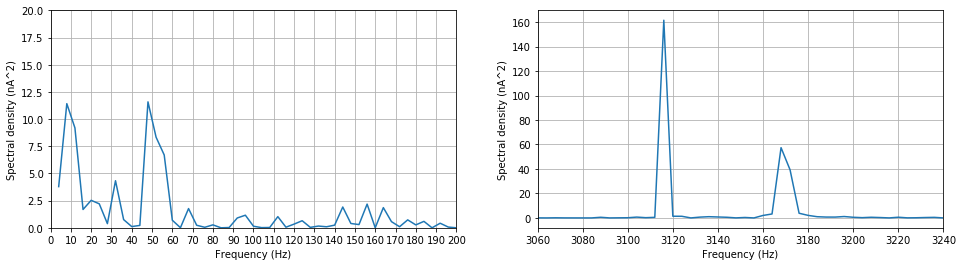

In [15]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)
ax.set_xlim(0, 200)
ax.set_ylim(0, 20)
ax.set_xticks(np.arange(0, 210, 10))
ax.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density (nA^2)')
ax.plot(freq, points)
ax.set_xlim(3060, 3240)
ax.set_xticks(np.arange(3060, 3260, 20))
ax.grid(True)

plt.show()

Starting on the right again, we see two large peaks at around $3115 \text{Hz}$ and $3170 \text{Hz}$.
If we assume this noise is from something man-made, we might expect the frequencies to be nice round numbers, so it can be worth googling our frequency estimates to see if anyone knows what's causing them!
Judging from the fact that we see these clear signals in cell 7, but not cell 1, we might suspect it's something that gets switched on and off during the day, but it could also come from something like a fridge which switches itself on from time to time.

On the left, we see a peak of unknown origins at $10 \text{Hz}$, but also one at $50 \text{Hz}$, which is a clear example of ["mains hum"](https://en.wikipedia.org/wiki/Mains_hum).

So how do we use this knowledge?

One option, especially when the peaks are as sharp as shown above, is to digitally filter out one of the frequencies.
We could also try fitting sine waves and subtracting them from the signal, or including the sine waves in our (noise) model.
But we could also observe that the strongest peaks are of a much higher frequency than what we expect from the current of interest, and that the lower frequency peaks are quite small.
So it might be fine to just leave the noise in, avoiding the risk of our "corrections" making things worse, and to present the data to our optimisation routine as-is.
Zooming out and observing the whole signal, this doesn't seem too bad an idea, and indeed this is the approach we took in e.g. [Four ways to fit an ion channel model](https://doi.org/10.1016/j.bpj.2019.08.001).

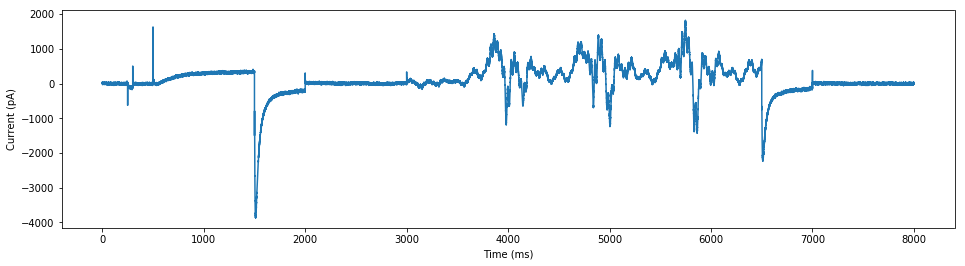

In [16]:
# The full signal for cell 7
log = myokit.DataLog.load('resources/sine-wave-data/cell-7.zip').npview()

# Show the results
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')
ax.plot(log.time(), log['current'] * 1e3)
plt.show()

## Summary


In this notebook, we 

- Briefly introduced the idea of separating the measured current $I_\text{measured}$ from the current of interest $I_\text{ion}$, and noted that the membrane voltage $V_m$ is not always the intended voltage $V_\text{command}$.
- Listed four strategies for dealing with these distortions
- Looked at stochastic additive noise (which we dealt with using online filtering and offline modelling)
- Looked at periodic noise (which we decided to treat as if it was stochastic!)

In the next notebook, we will look at some more complicated ways in which the measurements can be distorted, starting with capacitance artefacts and series resistance.